In [132]:
import sys
sys.path.append('../scripts')

import proplot as pplt
import pandas as pd
from helpers import *
from scipy import stats
import numpy as np

def jointDistribution(df:pd.DataFrame, var1:str, var2:str, category:str, binx:int = 5, biny:int = 5):
    pass

                       value
latitude mean:     86.575889
longitude mean:   113.152759
latitude min:      85.647310
longitude min:     92.485110
latitude max:      87.571230
longitude max:    125.461760

                      value
latitude mean:    84.275793
longitude mean:   20.826124
latitude min:     78.777430
longitude min:    -2.380620
latitude max:     88.591080
longitude max:    95.336030



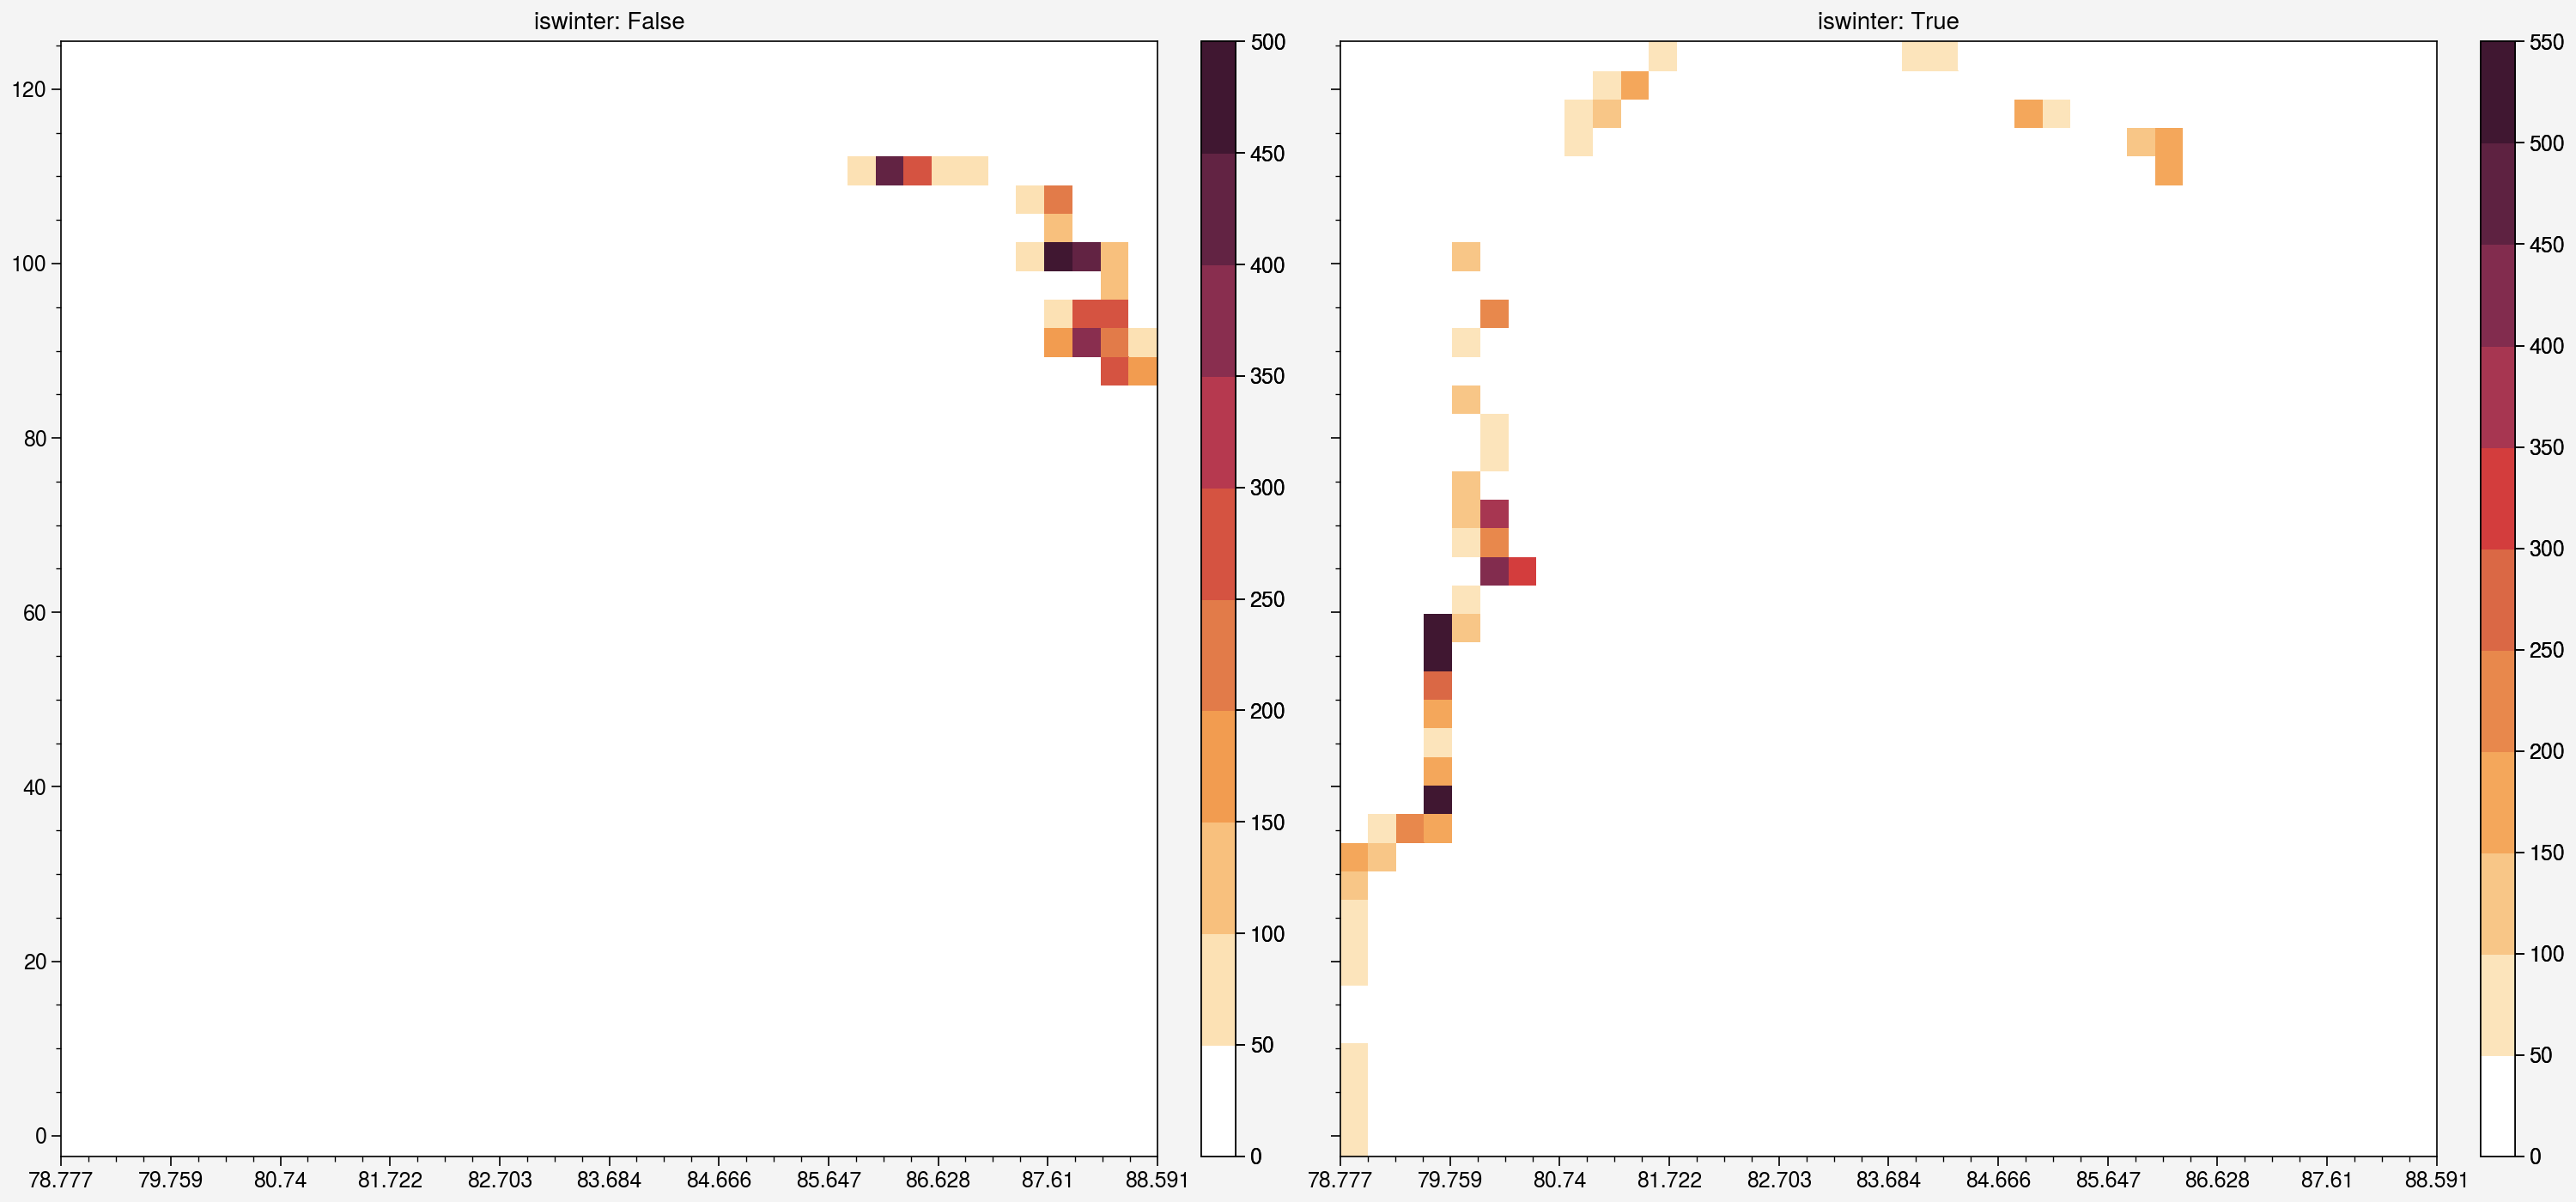

In [181]:
var1 = "latitude"
var2 = "longitude"
category = "iswinter"

df = buoy_data("2019T62")
df = df.assign(iswinter = lambda x: pd.to_datetime(x.datetime) > pd.to_datetime("2020-02-02"))

vars = df[[var1, var2, category]]
groups = vars.groupby(category)
fig, axs = pplt.subplots(ncols=len(groups), figsize=(15,7))

x_bins = np.linspace(vars[var1].min(), vars[var1].max(), 40)
y_bins = np.linspace(vars[var2].min(), vars[var2].max(), 40)

for i, group in enumerate(groups):
    title = group[0]
    data = group[1]

    binned = stats.binned_statistic_2d(data[var1], data[var2], None, "count", bins=[x_bins, y_bins])

    c = axs[i].pcolor(x_bins, y_bins, binned.statistic)
    fig.colorbar(c, ax=axs[i])

    axs[i].format(title=f"{category}: {title}", xlocator="linear")
    

    summary = {
        f"{var1} mean: ": data[var1].mean(),
        f"{var2} mean: ": data[var2].mean(),
        f"{var1} min: ": data[var1].min(),
        f"{var2} min: ": data[var2].min(),
        f"{var1} max: ": data[var1].max(),
        f"{var2} max: ": data[var2].max(),
    }
    print(pd.DataFrame(summary, index=["value"]).transpose())
    print()